# ***FakeMind-ML4VA Project: Detecting Droughts in Virginia***

Team FakeMind is composed of three UVA students: Alex Fetea, Kamil Urbanowski, and Tyler Kim. FakeMind's goal is to predict droughts in Virginia using a dataset found online. This will help farmers take better care of their farms by taking preparing ahead of time for possible droughts.

The link to the datasets can be found below:

https://resilience.climate.gov/datasets/esri2::us-drought-by-state/explore

https://www.ncei.noaa.gov/products/land-based-station/global-historical-climatology-network-daily


In general, this notebook will store our code for the ML4VA project. This notebook will also be divided into 8 Steps:

1. Big Picture & Setup
2. Getting the Data
3. Discovering and Visualizing the Data
4. Data Cleaning
5. Selecting and Training the Models
6. Fine Tuning the Model
7. Presentation
8. Launch


## **1-Big Picture & Setup**

In [5]:
# import the necessary libraries
import sklearn
import numpy as np
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd

np.random.seed(17)

## **2-Getting the Data**

In [7]:
def load_data(filepath):
    # Read the dataset
    data = pd.read_csv(filepath)

    # Calculate file size in MB
    file_size = os.path.getsize(filepath) / (1024 * 1024)  # Convert bytes to MB

    # Count number of entries and features
    num_entries, num_features = data.shape

    # Count number of categorical features
    num_categorical = sum(data.dtypes == 'object')

    # Check for missing values
    missing_value_exists = data.isnull().values.any()

    # Print the output
    print("File Size: {:.2f} MB".format(file_size))
    print("Number of Entries:", num_entries)
    print("Number of Features:", num_features)
    print("Do Categorical variables exist:", "Yes" if num_categorical > 0 else "No", "({})".format(num_categorical))
    print("Do missing values exist:", "Yes" if missing_value_exists else "No")
    print("\n")

    print(data.info())
    print(data.describe())

    return data


In [8]:
# loads the data
drought_data = load_data("datasets\merged_weather_drought.csv")

File Size: 10.41 MB
Number of Entries: 62313
Number of Features: 24
Do Categorical variables exist: Yes (3)
Do missing values exist: Yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62313 entries, 0 to 62312
Data columns (total 24 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   OBJECTID    62313 non-null  int64  
 1   state_abbr  62313 non-null  object 
 2   admin_fips  62313 non-null  int64  
 3   ddate       62313 non-null  object 
 4   nothing     62272 non-null  float64
 5   d0          62270 non-null  float64
 6   d1          62292 non-null  float64
 7   d2          62299 non-null  float64
 8   d3          62302 non-null  float64
 9   d4          62309 non-null  float64
 10  D0_D4       62272 non-null  float64
 11  D1_D4       62294 non-null  float64
 12  D2_D4       62300 non-null  float64
 13  D3_D4       62302 non-null  float64
 14  time        58022 non-null  object 
 15  tavg        52733 non-null  float64
 16  tmin     

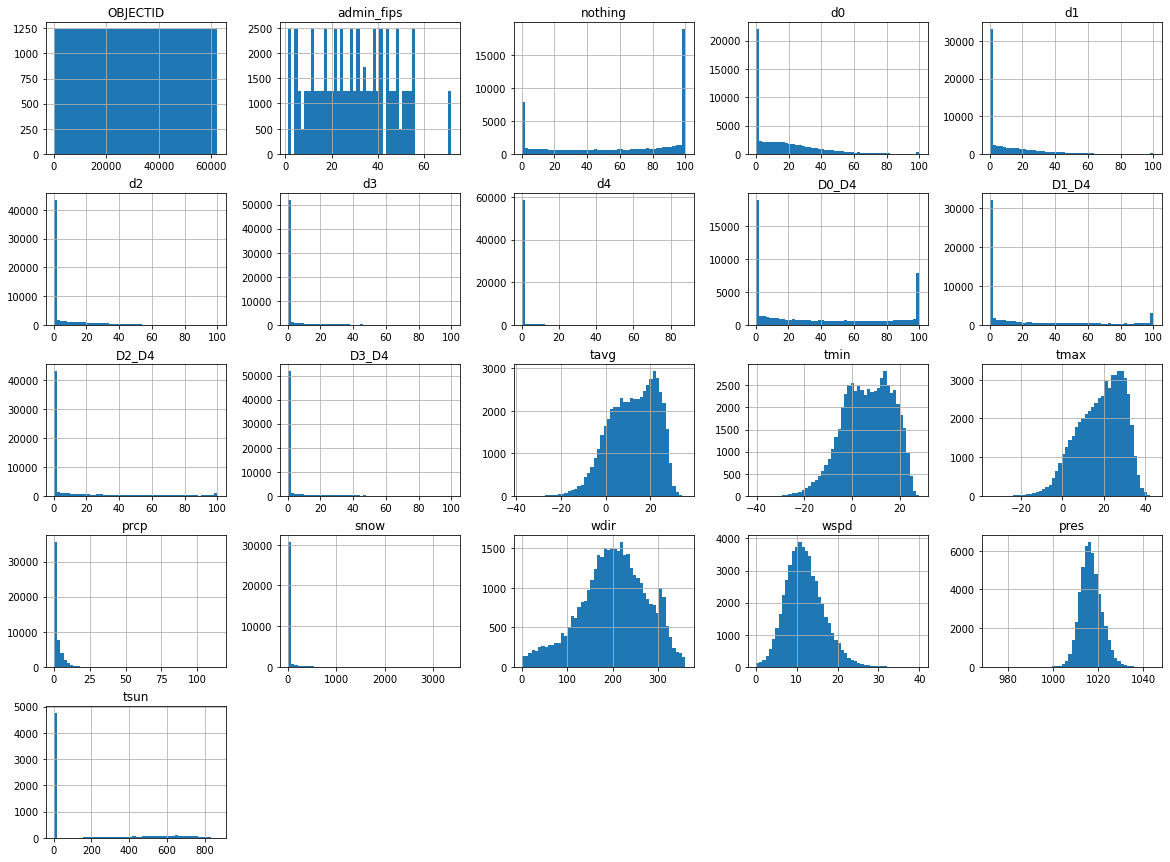

In [9]:
%matplotlib inline
drought_data.hist(bins = 50, figsize = (20, 15))
plt.show()

## **3-Discovering and Visualizing the Data**

          OBJECTID   admin_fips      nothing           d0           d1  \
count   8694.00000  8694.000000  8688.000000  8688.000000  8694.000000   
mean   32758.05107    35.000000    72.557658    15.205475     7.536473   
std    16719.02200    15.391049    35.208546    22.124544    17.306032   
min     4543.00000    11.000000     0.000000     0.000000     0.000000   
25%    15043.25000    21.000000    48.990000     0.000000     0.000000   
50%    33870.50000    37.000000    92.925000     3.535000     0.000000   
75%    46166.25000    51.000000   100.000000    23.750000     6.060000   
max    62309.00000    54.000000   100.000000   100.000000   100.000000   

                d2           d3           d4        D0_D4        D1_D4  ...  \
count  8694.000000  8694.000000  8694.000000  8688.000000  8694.000000  ...   
mean      3.097177     1.221370     0.373401    27.442342    12.228422  ...   
std      11.033349     6.905724     3.592476    35.208546    25.723340  ...   
min       0.00000

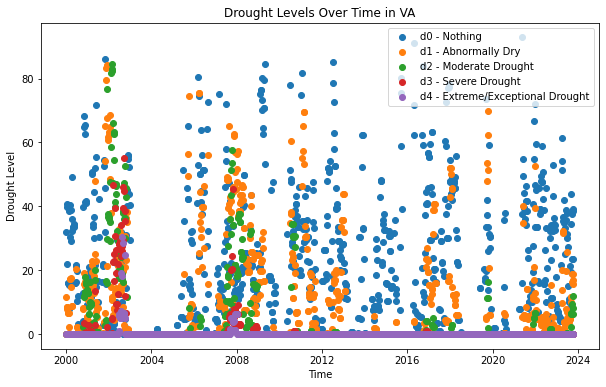

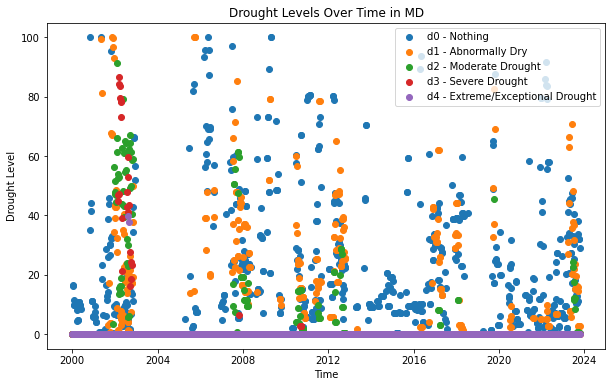

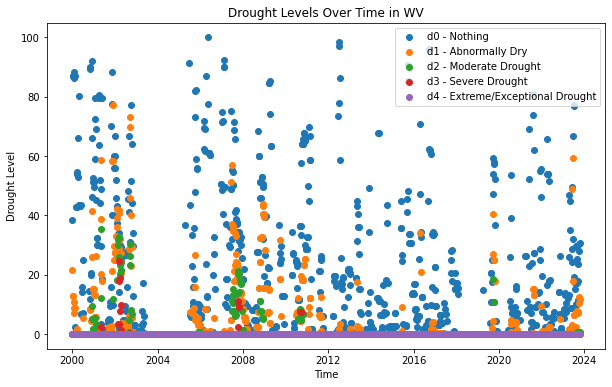

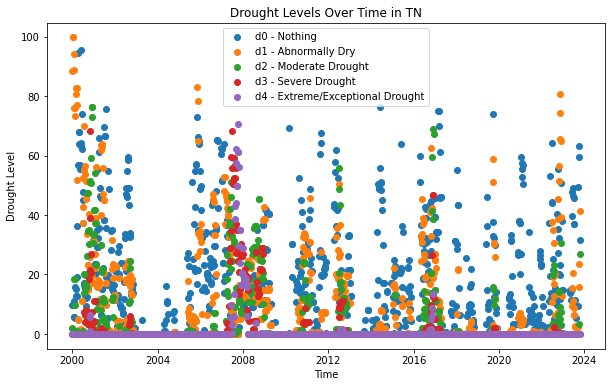

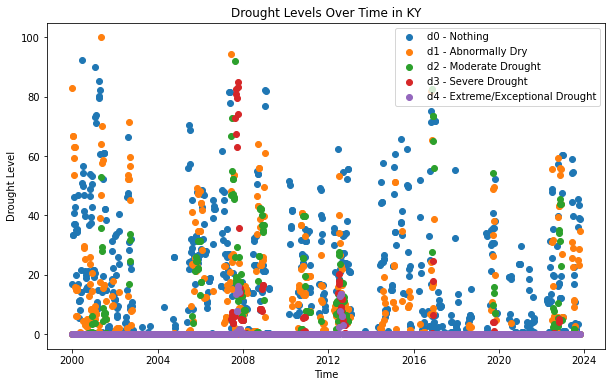

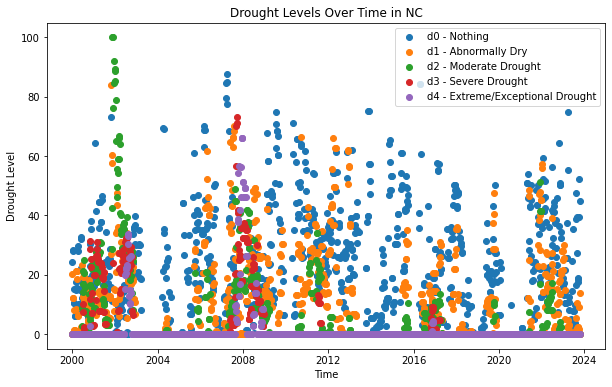

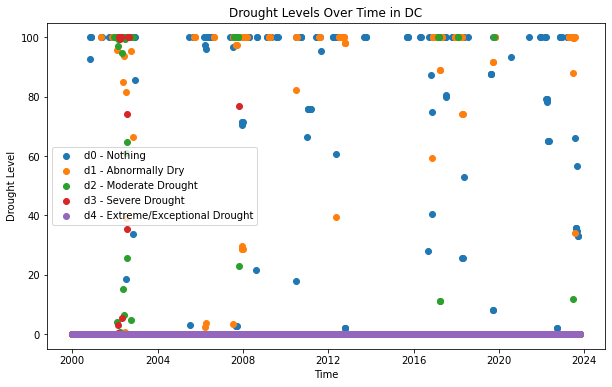

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming drought_data is your original DataFrame

# Filter for states of interest and create a copy
states_of_interest = ["VA", "MD", "WV", "TN", "KY", "NC", "DC"]
sub_df = drought_data[drought_data['state_abbr'].isin(states_of_interest)].copy()

# Convert 'ddate' to datetime
sub_df['ddate'] = pd.to_datetime(sub_df['ddate'])

# Basic Statistics
print(sub_df.describe())

# Create separate scatter plots for each state
for state in states_of_interest:
    plt.figure(figsize=(10, 6))
    state_data = sub_df[sub_df['state_abbr'] == state]

    plt.scatter(state_data['ddate'], state_data['d0'], label="d0 - Nothing")
    plt.scatter(state_data['ddate'], state_data['d1'], label="d1 - Abnormally Dry")
    plt.scatter(state_data['ddate'], state_data['d2'], label="d2 - Moderate Drought")
    plt.scatter(state_data['ddate'], state_data['d3'], label="d3 - Severe Drought")
    plt.scatter(state_data['ddate'], state_data['d4'], label="d4 - Extreme/Exceptional Drought")

    plt.xlabel('Time')
    plt.ylabel('Drought Level')
    plt.title(f'Drought Levels Over Time in {state}')
    plt.legend()
    plt.show()

# Optionally, create a correlation heatmap as previously described...


The scatterplots above represent the level of drought for VA and other adjacent states. It seems as if many of the states have a tendency to be abnormally dry but rarely have anything worse.

## **4-Data Cleaning**

Will drop some features since some of it is redundant.

In [12]:
from sklearn.model_selection import train_test_split

# Define target and feature columns
output_list = ["nothing", "d0", "d1", "d2", "d3", "d4"]
feature_cols = [col for col in drought_data.columns if col not in output_list and col not in ['D0_D4', 'D1_D4', 'D2_D4', 'D3_D4']]

# Split the data into training and testing sets
train_set, test_set = train_test_split(drought_data, test_size=0.2, random_state=17)

# Separate features and target for training data
X_train = train_set[feature_cols]
y_train = train_set[output_list]

print(y_train.head())
print(X_train.head())

       nothing     d0     d1   d2    d3   d4
45145   100.00   0.00   0.00  0.0   0.0  0.0
30937    53.22  46.78   0.00  0.0   0.0  0.0
38304    19.49  43.02  19.19  0.0  18.3  0.0
4339    100.00   0.00   0.00  0.0   0.0  0.0
35762    71.47  28.53   0.00  0.0   0.0  0.0
       OBJECTID state_abbr  admin_fips       ddate        time       tavg  \
45145     45146         VA          51  2017-06-20  2017-06-20  23.614286   
30937     30938         SD          46  2001-11-27  2001-11-27   1.142857   
38304     38305         KS          20  2014-12-16  2014-12-16   6.700000   
4339       4340         CT           9  2003-11-18  2003-11-18   5.000000   
35762     35763         WV          54  2010-12-28  2010-12-28  -4.300000   

            tmin       tmax      prcp        snow   wdir       wspd  \
45145  19.371429  29.371429  5.314286    0.000000    NaN   8.842857   
30937  -2.314286   4.600000  0.000000         NaN  174.0  24.428571   
38304   3.485714  10.400000  0.000000         NaN  249

In [13]:
# Test distributions
print(X_train["state_abbr"].value_counts() / len(X_train))
print(drought_data["state_abbr"].value_counts() / len(drought_data))

NH    0.020341
AK    0.020301
AZ    0.020281
MN    0.020241
FL    0.020221
AL    0.020201
MT    0.020201
WA    0.020181
AR    0.020181
SC    0.020181
MI    0.020160
OH    0.020160
NV    0.020160
GA    0.020120
OR    0.020120
MS    0.020100
VA    0.020100
TX    0.020040
IN    0.020020
NC    0.020000
KY    0.020000
NE    0.020000
IL    0.019980
UT    0.019980
DE    0.019960
SD    0.019940
MD    0.019940
MA    0.019940
NJ    0.019940
IA    0.019900
ID    0.019900
NY    0.019860
RI    0.019840
HI    0.019819
WI    0.019819
MO    0.019799
CT    0.019779
PA    0.019719
CA    0.019719
ND    0.019699
WV    0.019699
LA    0.019679
OK    0.019639
ME    0.019639
TN    0.019639
WY    0.019478
DC    0.019478
PR    0.019458
KS    0.019418
CO    0.007763
NM    0.007683
VT    0.007583
Name: state_abbr, dtype: float64
CT    0.019932
WY    0.019932
MO    0.019932
MI    0.019932
SD    0.019932
DC    0.019932
MA    0.019932
AL    0.019932
OR    0.019932
MT    0.019932
OK    0.019932
RI    0.019932
NH    0

In [14]:

import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

# Define the pipeline for numeric and categorical attributes
num_attribs = list(X_train.select_dtypes(include=np.number))
cat_attribs = list(X_train.select_dtypes(exclude=np.number))

num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),  # Impute with mean
    ("std_scaler", StandardScaler()),
])

full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", OneHotEncoder(), cat_attribs),
])

In [15]:
# Apply the full pipeline to the training data
X_train_prepared = full_pipeline.fit_transform(X_train).toarray()

print(y_train)

# Converting to one-hot encoded format
y_train_one_hot = np.zeros_like(y_train.values)
y_train_one_hot[np.arange(len(y_train.values)), y_train.values.argmax(axis=1)] = 1

# Convert back to DataFrame
y_train_one_hot_df = pd.DataFrame(y_train_one_hot, columns=y_train.columns)

print(y_train_one_hot_df.head())


       nothing     d0     d1     d2     d3     d4
45145   100.00   0.00   0.00   0.00   0.00   0.00
30937    53.22  46.78   0.00   0.00   0.00   0.00
38304    19.49  43.02  19.19   0.00  18.30   0.00
4339    100.00   0.00   0.00   0.00   0.00   0.00
35762    71.47  28.53   0.00   0.00   0.00   0.00
...        ...    ...    ...    ...    ...    ...
42297     4.27  11.82  24.89  16.03  21.95  21.04
33174     0.00   0.00  10.25  26.45  29.86  33.44
46470    40.47   8.48  21.50  29.55   0.00   0.00
34959    73.04  26.96   0.00   0.00   0.00   0.00
10863   100.00   0.00   0.00   0.00   0.00   0.00

[49850 rows x 6 columns]
   nothing   d0   d1   d2   d3   d4
0      1.0  0.0  0.0  0.0  0.0  0.0
1      1.0  0.0  0.0  0.0  0.0  0.0
2      0.0  1.0  0.0  0.0  0.0  0.0
3      1.0  0.0  0.0  0.0  0.0  0.0
4      1.0  0.0  0.0  0.0  0.0  0.0


## **5-Selecting and Training the Models**

In [21]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import LSTM, Dense, Dropout, Bidirectional, BatchNormalization, InputLayer

num_samples = X_train_prepared.shape[0]
num_features = X_train_prepared.shape[1]
num_outputs = y_train_one_hot_df.shape[1]
timesteps = X_train_prepared.size // (num_samples * num_features)

# Reshape the data
X_train_prepared_reshaped = X_train_prepared.reshape((num_samples, timesteps, num_features))

# Define hyperparameters
num_units = [50, 50]  # Number of LSTM units in each layer
dropout_rate = 0.3  # Dropout rate
learning_rate = 0.001  # Learning rate
epochs = 14  # Number of training epochs
validation_split = 0.1  # Validation split

# Model building function for RNN classification
def build_rnn_classification_model(input_shape, num_units=num_units, num_outputs=num_outputs, dropout_rate=dropout_rate):
    model = keras.models.Sequential()
    
    # Input layer
    model.add(keras.layers.InputLayer(input_shape=input_shape))

    # LSTM layers with Bidirectional and Layer Normalization
    for i, n_unit in enumerate(num_units):
        return_sequences = i < len(num_units) - 1
        model.add(Bidirectional(LSTM(n_unit, return_sequences=return_sequences)))
        model.add(BatchNormalization())
        model.add(Dropout(dropout_rate))

    # Output layer for multi-class classification
    model.add(Dense(num_outputs, activation='softmax'))

    # Compile the model
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    return model

# Building and compiling the RNN model
input_shape = (timesteps, num_features)
rnn_classification_model = build_rnn_classification_model(input_shape)

# Model summary
rnn_classification_model.summary()


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_2 (Bidirection (None, 1, 100)            1038800   
_________________________________________________________________
batch_normalization_2 (Batch (None, 1, 100)            400       
_________________________________________________________________
dropout_4 (Dropout)          (None, 1, 100)            0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 100)               60400     
_________________________________________________________________
batch_normalization_3 (Batch (None, 100)               400       
_________________________________________________________________
dropout_5 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                

In [22]:
# Train the model
history = rnn_classification_model.fit(
    X_train_prepared_reshaped,
    y_train_one_hot_df,
    epochs=epochs,
    validation_split=validation_split
)

Epoch 1/14
1403/1403 [==============================] - 57s 24ms/step - loss: 1.1222 - accuracy: 0.6315 - val_loss: 0.9021 - val_accuracy: 0.6927
Epoch 2/14
1403/1403 [==============================] - 29s 21ms/step - loss: 0.8995 - accuracy: 0.6898 - val_loss: 0.8495 - val_accuracy: 0.7011
Epoch 3/14
1403/1403 [==============================] - 29s 21ms/step - loss: 0.8395 - accuracy: 0.7007 - val_loss: 0.8133 - val_accuracy: 0.7115
Epoch 4/14
1403/1403 [==============================] - 28s 20ms/step - loss: 0.7882 - accuracy: 0.7114 - val_loss: 0.7803 - val_accuracy: 0.7163
Epoch 5/14
1403/1403 [==============================] - 29s 21ms/step - loss: 0.7399 - accuracy: 0.7278 - val_loss: 0.7526 - val_accuracy: 0.7242
Epoch 6/14
1403/1403 [==============================] - 23s 16ms/step - loss: 0.6944 - accuracy: 0.7428 - val_loss: 0.7344 - val_accuracy: 0.7302
Epoch 7/14
1403/1403 [==============================] - 24s 17ms/step - loss: 0.6583 - accuracy: 0.7518 - val_loss: 0.7185 -

In [65]:
keras.backend.clear_session()
np.random.seed(42)

## **6-Fine Tuning the Model**

## **7-Presentation**

## **8-Launch**